# Diagram bifurkacyjny dla równania logistycznego $x \to a x (1-x)$

Równanie logistyczne jest niezwykle prostym równaniem iteracyjnym wykazującym zaskakująco złożone zachowanie. Jego własności są od lat siedemdziesiątych przedmiotem poważnych prac matematycznych. Pomimo tego wciąż wiele własności jest niezbadanych i zachowanie się rozwiązań tego równania jest dostępne tylko do analizy numerycznej.

Poniższy przykład wykorzystuje pyCUDA do szybkiego obliczenia tak zwanego diagramu bifurkacyjnego równania logistycznego. Uzyskanie takiego diagramu wymaga jednoczesnej symulacji wielu równań z różnymi warunkami początkowymi i różnymi parametrami. Jest to idealne zadanie dla komputera równoległego.

Sposób implementacji
--------------------

Pierwszą implementacja naszego algorytmu będzie zastosowanie szablonu jądra zwanego 
    ElementwiseKernel

Jest to prosty sposób na wykonanie tej samej operacji na dużym wektorze danych. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:

import pycuda.gpuarray as gpuarray

from pycuda.curandom import rand as curand
from pycuda.compiler import SourceModule
import pycuda.driver as cuda

try:
    ctx.pop()
    ctx.detach()
except:
    print ("No CTX!")

cuda.init()
device = cuda.Device(0)
ctx = device.make_context()
print (device.name(), device.compute_capability(),device.total_memory()/1024.**3,"GB")
print ("a tak wogóle to mamy tu:",cuda.Device.count(), " urządzenia")


No CTX!
Tesla K40m (3, 5) 11.1717529296875 GB
a tak wogóle to mamy tu: 2  urządzenia


## Jądro Elementwise

Zdefiniujemy sobie jądro, które dla wektora stanów początkowych, element po  elementcie wykona iteracje rówania logistycznego. Ponieważ będziemy chcieli wykonać powyższe iteracje dla różnych parametrów $a$, zdefiniujemy nasze jądro tak by brało zarówno wektor wartości paramteru $a$ jak i wektor wartości początkowych. Ponieważ będziemy mieli tą samą wartość parametru $a$ dla wielu wartości początkowych to wykorzystamy użyteczną w tym przypadku funkcję numpy:

    a =  np.repeat(a,Nx)

In [25]:
import numpy as np 
Nx = 1024
Na = 1024

a = np.linspace(3.255,4,Na).astype(np.float32)
a =  np.repeat(a,Nx)

a_gpu = gpuarray.to_gpu(a)
x_gpu = curand((Na*Nx,))

from pycuda.elementwise import ElementwiseKernel
iterate = ElementwiseKernel(
        "float *a, float *x",
        "x[i] = a[i]*x[i]*(1.0f-x[i])",
        "iterate")


In [26]:
%%time
Niter = 1000
for i in range(Niter):
    iterate(a_gpu,x_gpu)
ctx.synchronize()
a,x = a_gpu.get(),x_gpu.get()


CPU times: user 120 ms, sys: 8 ms, total: 128 ms
Wall time: 253 ms


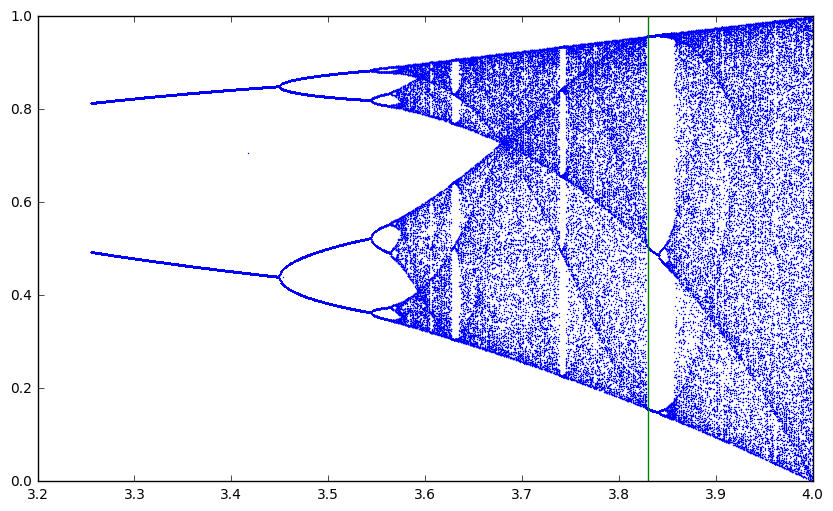

In [27]:

plt.figure(num=1, figsize=(10, 6))

every = 10
plt.plot(a[::every],x[::every],'.',markersize=1)
plt.plot([3.83,3.83],[0,1])

## Algorytm z pętlą wewnątrz jądra CUDA

Napiszmy teraz algorytm, który będzie iterował równanie `Niter` razy wewnątrz jednego wywołania jądra CUDA.

In [7]:
import pycuda.gpuarray as gpuarray

from pycuda.curandom import rand as curand
from pycuda.compiler import SourceModule
import pycuda.driver as cuda

try:
    ctx.pop()
    ctx.detach()
except:
    print( "No CTX!")

cuda.init()
device = cuda.Device(0)
ctx = device.make_context()


mod = SourceModule("""
    __global__ void logistic_iterations(float *a,float *x,int Niter)
    {
      
      int idx = threadIdx.x + blockDim.x*blockIdx.x;
      float a_ = a[idx];
      float x_ = x[idx];
      int i;
      for (i=0;i<Niter;i++){
        
          x_ = a_*x_*(1-x_);
      }
      
      x[idx] = x_;
    }
    """)
logistic_iterations = mod.get_function("logistic_iterations")

In [21]:

block_size=128
Nx = 10240
Na = 1024*2
blocks = Nx*Na//block_size

a = np.linspace(3.255,4,Na).astype(np.float32)
a = np.repeat(a,Nx)

a_gpu = gpuarray.to_gpu(a)
x_gpu = curand((Na*Nx,))

In [22]:
%%time
logistic_iterations(a_gpu,x_gpu, np.int32(10000),block=(block_size,1,1), grid=(blocks,1,1))
ctx.synchronize()

CPU times: user 888 ms, sys: 116 ms, total: 1 s
Wall time: 1 s


In [23]:

a,x = a_gpu.get(),x_gpu.get()

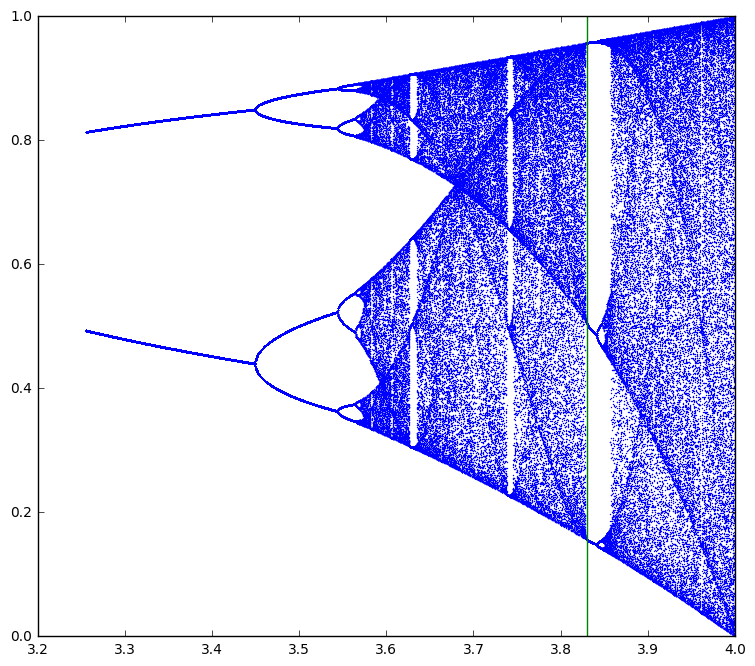

In [24]:
plt.figure(num=1, figsize=(9, 8))
every = 100
plt.plot(a[::every],x[::every],'.',markersize=1,alpha=1)
plt.plot([3.83,3.83],[0,1])

In [13]:
H, xedges, yedges = np.histogram2d(a,x,bins=(1024,1024))

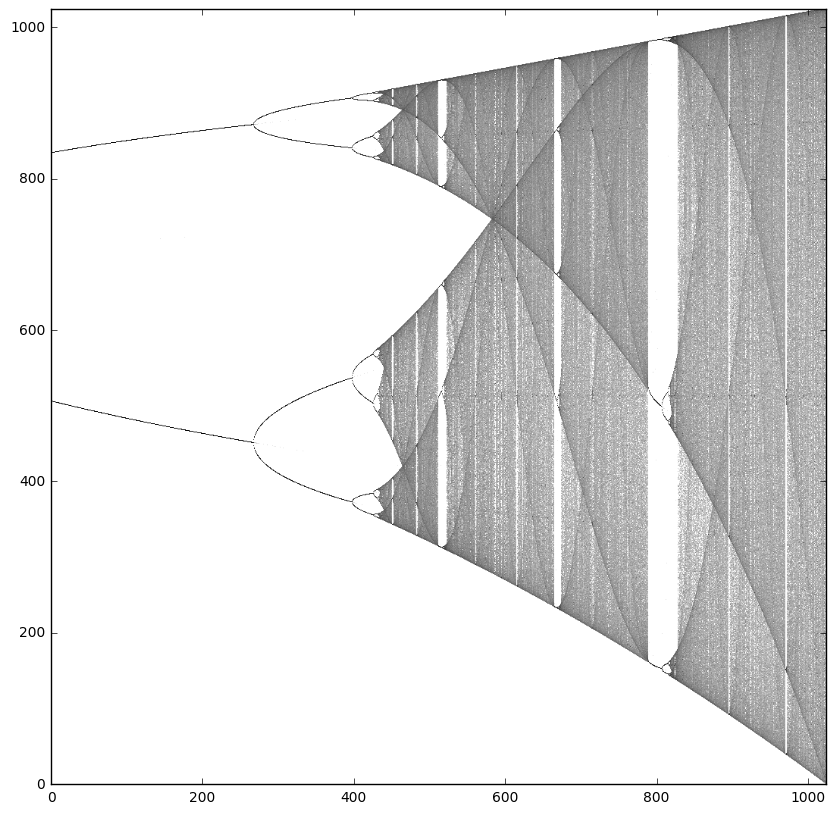

In [14]:
plt.figure(num=1, figsize=(10,10))

plt.imshow(1-np.log(H.T+5e-1),origin='lower',cmap='gray')

## Porównanie z wersją CPU

Dla porównania napiszemy prosty program, który oblicza iteracje równania logistycznego na CPU. Zatosujemy język cython, który umożliwia automatyczne skompilowanie funkcji do wydajnego kodu, którego wydajność jest porównywalna z kodem napisanym w języku C lub podobnym.

W wyniku działania programu widzimy, że nasze jądro wykonuje obliczenia znacznie szybciej.

In [15]:
%load_ext Cython

In [16]:
%%cython
def logistic_cpu(double a = 3.56994):
    cdef double x
    
    cdef int i
    x = 0.1
    for i in range(1000*1024*1024):
        x = a*x*(1.0-x)
        
    return x

In [17]:
%%time
logistic_cpu(1.235)

CPU times: user 3.37 s, sys: 0 ns, total: 3.37 s
Wall time: 3.34 s


0.19028340080971662

In [18]:
print("OK")

OK


## Wizualizacja wyników

/opt/conda/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


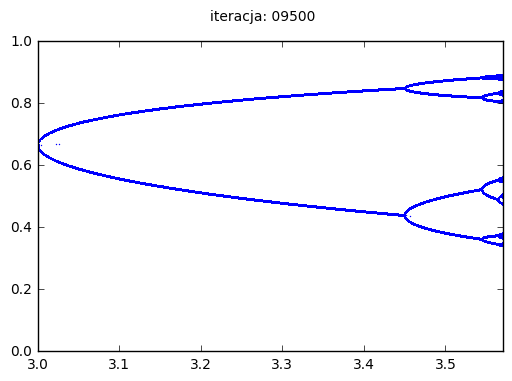

In [31]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
a1,a2 = 3,3.56994567

Nx = 1024
Na = 1024

a = np.linspace(a1,a2,Na).astype(np.float32)
a =  np.repeat(a,Nx)

a_gpu = gpuarray.to_gpu(a)
x_gpu = curand((Na*Nx,))
x = x_gpu.get()

fig = plt.figure()

every = 1
Niter = 10000
for i in range(Niter):
    if i%every==0:
        
        plt.cla()
        
        plt.xlim(a1,a2)

        plt.ylim(0,1)
        fig.suptitle("iteracja: %05d"%i)
        plt.plot(a,x,'.',markersize=1)
        plt.savefig("/tmp/%05d.png"%i)
    if i>10:
        every=2
    if i>30:
        every=10
    if i>100:
        every=50 
    if i>1000:
        every=500    
    iterate(a_gpu,x_gpu)
    ctx.synchronize()
    a,x = a_gpu.get(),x_gpu.get()



In [32]:
%%sh 
cd /tmp
time convert   -delay 20   -loop 0 *.png anim_double.gif && rm *.png

3.63user 3.46system 0:07.10elapsed 99%CPU (0avgtext+0avgdata 292264maxresident)k
9392inputs+1176outputs (40major+2166487minor)pagefaults 0swaps


In [35]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

block_size=128
Nx = 1024*5
Na = 1024*3
blocks = Nx*Na//block_size

nframes = 22
for i,(a1,a2) in enumerate(zip(np.linspace(3,3.77,nframes),np.linspace(4,3.83,nframes))):

    a = np.linspace(a1,a2,Na).astype(np.float32)
    a =  np.repeat(a,Nx)

    a_gpu = gpuarray.to_gpu(a)
    x_gpu = curand((Na*Nx,))
    x = x_gpu.get()

    
    logistic_iterations(a_gpu,x_gpu, np.int32(10000),block=(block_size,1,1), grid=(blocks,1,1))
    ctx.synchronize()

    a,x = a_gpu.get(),x_gpu.get()
    H, xedges, yedges = np.histogram2d(a,x,bins=(np.linspace(a1,a2,1024),np.linspace(0,1,1024)))

    fig, ax = plt.subplots(figsize=[10,7])
    
    ax.imshow(1-np.log(H.T+5e-1),origin='lower',cmap='gray',extent=[a1,a2,0,1])
    #plt.xlim(a1,a2)
    #plt.ylim(0,1)
    ax.set_aspect(7/10*(a2-a1))
    #fig.set_size_inches(8, 5)

    fig.savefig("/tmp/zoom%05d.png"%i)
    plt.close(fig)

/opt/conda/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [37]:
%%sh 
cd /tmp
time convert   -delay 30   -loop 0 *.png anim_zoom.gif   && rm *.png

convert: unable to open image `*.png': No such file or directory @ error/blob.c/OpenBlob/2712.
convert: unable to open file `*.png' @ error/png.c/ReadPNGImage/3922.
convert: no images defined `anim_zoom.gif' @ error/convert.c/ConvertImageCommand/3210.
Command exited with non-zero status 1
0.00user 0.00system 0:00.02elapsed 14%CPU (0avgtext+0avgdata 7732maxresident)k
104inputs+0outputs (2major+439minor)pagefaults 0swaps


In [38]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

block_size=128
Nx = 1024*5
Na = 1024*3
blocks = Nx*Na//block_size

a1,a2 = 1,4
x1,x2 = 0., 1

a = np.linspace(a1,a2,Na).astype(np.float32)
a =  np.repeat(a,Nx)

a_gpu = gpuarray.to_gpu(a)
x_gpu = curand((Na*Nx,))
x = x_gpu.get()


logistic_iterations(a_gpu,x_gpu, np.int32(10000),block=(block_size,1,1), grid=(blocks,1,1))
ctx.synchronize()

a,x = a_gpu.get(),x_gpu.get()
H, xedges, yedges = np.histogram2d(a,x,bins=(np.linspace(a1,a2,1024),np.linspace(x1,x2,1024)))

fig, ax = plt.subplots(figsize=[10,7])

ax.imshow(1-np.log(H.T+5e-1),origin='lower',cmap='gray',extent=[a1,a2,x1,x2])
#plt.xlim(a1,a2)
#plt.ylim(0,1)
ax.set_aspect(7/10*(a2-a1)/(x2-x1))
#fig.set_size_inches(8, 5)

fig.savefig("/tmp/zoom.png")
plt.close(fig)

/opt/conda/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
